In [1]:
import pandas as pd

df = pd.read_csv('normalized_feature_set.csv', encoding='ISO-8859-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35148 entries, 0 to 35147
Data columns (total 11 columns):
indicator_types.value                                35148 non-null object
kill_chain_phases.kill_chain_phases.ordinality       35148 non-null float64
ip_score                                             35148 non-null float64
url_score                                            35148 non-null float64
observable.object.properties.hashes.type.value       35148 non-null int64
observable.object.properties.header.subject.value    35148 non-null int64
observable.object.properties.size_in_bytes.value     35148 non-null float64
tlp_marking_color                                    35148 non-null object
target                                               35148 non-null object
hash_score                                           35148 non-null float64
file_type                                            35148 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 2.9+ MB


## Splitting the dataset into Watchlist and other categories

In [2]:
df_tmp = pd.DataFrame()
frames_watchlist = [df_tmp]
frames_malicious = [df_tmp]

for indicator, df_indicator in df.groupby('indicator_types.value'):
    if 'Watchlist' in indicator:
        frames_watchlist.append(df_indicator)
    else:
        frames_malicious.append(df_indicator)
        
df_watchlist = pd.concat(frames_watchlist)
df_malicious = pd.concat(frames_malicious)

print df_watchlist.info()
print df_malicious.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34183 entries, 389 to 35114
Data columns (total 11 columns):
indicator_types.value                                34183 non-null object
kill_chain_phases.kill_chain_phases.ordinality       34183 non-null float64
ip_score                                             34183 non-null float64
url_score                                            34183 non-null float64
observable.object.properties.hashes.type.value       34183 non-null int64
observable.object.properties.header.subject.value    34183 non-null int64
observable.object.properties.size_in_bytes.value     34183 non-null float64
tlp_marking_color                                    34183 non-null object
target                                               34183 non-null object
hash_score                                           34183 non-null float64
file_type                                            34183 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 3.1+ MB


## Adding IP scores and Hash scores greater than 0.4 to more malicious data

In [3]:
df_malicious_ip = df_watchlist[df_watchlist['ip_score'] > 0.4]
df_malicious_file = df_watchlist[df_watchlist['hash_score'] > 0.4]
df_watchlist = df_watchlist.drop(df_watchlist[df_watchlist.ip_score > 0.4].index)
df_watchlist = df_watchlist.drop(df_watchlist[df_watchlist.hash_score > 0.4].index)

# Making the ground truth as "malicious" for less malicious data
df_malicious = pd.concat([df_malicious, df_malicious_ip, df_malicious_file])
df_malicious['level'] = 'malicious'
df_malicious.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15687 entries, 32 to 34983
Data columns (total 12 columns):
indicator_types.value                                15687 non-null object
kill_chain_phases.kill_chain_phases.ordinality       15687 non-null float64
ip_score                                             15687 non-null float64
url_score                                            15687 non-null float64
observable.object.properties.hashes.type.value       15687 non-null int64
observable.object.properties.header.subject.value    15687 non-null int64
observable.object.properties.size_in_bytes.value     15687 non-null float64
tlp_marking_color                                    15687 non-null object
target                                               15687 non-null object
hash_score                                           15687 non-null float64
file_type                                            15687 non-null int64
level                                                15687 non-

In [4]:
# Making the ground truth as "suspicious" for more malicious data
df_watchlist['level'] = 'suspicious'
df_watchlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19461 entries, 389 to 35114
Data columns (total 12 columns):
indicator_types.value                                19461 non-null object
kill_chain_phases.kill_chain_phases.ordinality       19461 non-null float64
ip_score                                             19461 non-null float64
url_score                                            19461 non-null float64
observable.object.properties.hashes.type.value       19461 non-null int64
observable.object.properties.header.subject.value    19461 non-null int64
observable.object.properties.size_in_bytes.value     19461 non-null float64
tlp_marking_color                                    19461 non-null object
target                                               19461 non-null object
hash_score                                           19461 non-null float64
file_type                                            19461 non-null int64
level                                                19461 non

## Combining both the datasets and shuffling it

In [5]:
from sklearn.utils import shuffle

df_final = pd.concat([df_watchlist, df_malicious])
df_final = shuffle(df_final)

In [6]:
df_final.level = df_final.level.eq('suspicious').mul(1)

In [7]:
feature_list = ['kill_chain_phases.kill_chain_phases.ordinality',
                'ip_score',
                'url_score',
                'observable.object.properties.hashes.type.value',
                'observable.object.properties.header.subject.value',
                'observable.object.properties.size_in_bytes.value',
                'hash_score',
                'file_type'
               ]
X = df_final[feature_list]
Y = df_final['level']

## Normalizing all data between 0 and 1 for more accurate modeling

In [8]:
from sklearn import preprocessing

# Set charts to view inline
%matplotlib inline

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
X_scaled = min_max_scaler.fit_transform(X)

# Run the normalizer on the dataframe
X_normalized = pd.DataFrame(X_scaled)

X_normalized.head()

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


,0,1,2,3,4,5,6,7
0,0.0,0.852780,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.872625,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.804000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.891930,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting the dataset between training and testing

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y, test_size=0.5)

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Train different machine learning classifiers on the data

For Numerical Data

accuracy of "KNeighbors" model is 0.980198019802
accuracy of "Random Forest" model is 0.98628655969
accuracy of "Log Reg" model is 0.972004096961
accuracy of "Neural Networks" model is 0.977296005463
accuracy of "SVM" model is 0.976157960624




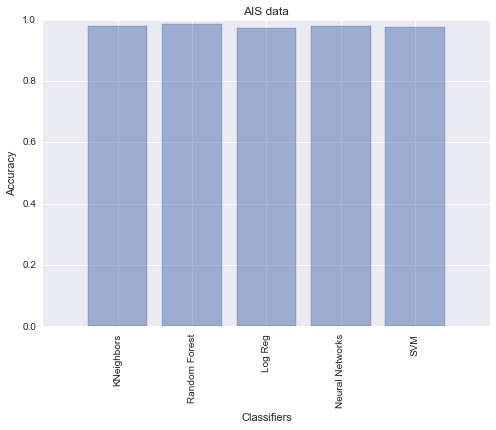

In [10]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn

names = ["KNeighbors", "Random Forest", "Log Reg", "Neural Networks", "SVM"]
y_pos = np.arange(len(names))

classifiers = [
    KNeighborsClassifier(100),
    RandomForestClassifier(n_estimators=100),
    LogisticRegression(),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(40, 20), random_state=1),
    SVC(C=100.),
    ]   

test = pd.DataFrame(names)
accuracy1 = []
accuracy2 = []
accuracy3 = []

print "For Numerical Data\n"
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    accu = metrics.accuracy_score(clf.predict(X_test), y_test)
    print 'accuracy of "{}" model is {}' .format(name, accu)
    accuracy1.append(accu)
    #print name
print "\n"

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('AIS data')
plt.bar(y_pos, accuracy1, align='center', alpha=0.5)
plt.xticks(y_pos, names, rotation='vertical')
plt.show()

## Producing metrics like Precision, Recall and F-1 score

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

clf = RandomForestClassifier().fit(X_train, y_train)
all_predictions = clf.predict(X_test)

//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [12]:
from sklearn.metrics import classification_report
print classification_report(y_test, all_predictions)

             precision    recall  f1-score   support

          0       0.99      0.98      0.98      7893
          1       0.98      0.99      0.99      9681

avg / total       0.99      0.99      0.99     17574



## Performing cross-validation on the results

In [13]:
from sklearn.cross_validation import cross_val_score
# compute the accuracy of predictions using accuracy
scores = cross_val_score(clf, X_normalized, Y, cv=10, scoring='accuracy')

for index, score in enumerate(scores):
    print 'Fold {}:{}'.format(index+1, score)

Fold 1:0.988054607509
Fold 2:0.984637268848
Fold 3:0.985490753912
Fold 4:0.98719772404
Fold 5:0.987482219061
Fold 6:0.987482219061
Fold 7:0.986059743954
Fold 8:0.990324416619
Fold 9:0.990324416619
Fold 10:0.985486624929


In [14]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.987253999455


## Plotting a decision tree based on the model

In [15]:
def Decision_Tree_Image(decision_tree, feature_names, name="temp"):
    # Export our decision tree to graphviz format
    #dot_file = tree.export_graphviz(decision_tree.tree_, out_file='images/' + name + '.dot', feature_names=feature_names)
    with open("images/temp.dot", 'w') as f:
        export_graphviz(decision_tree.tree_, out_file=f, feature_names=feature_names)

    # Call graphviz to make an image file from our decision tree
    os.system("dot -Tpng images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')

# A function to plot the data
def Plot_Data(data, v1, v2, tv):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) - 1, max(data[v1]) + 1])
    plt.ylim([min(data[v2]) - .05, max(data[v2]) + .05])
    
def Decision_Surface(x, y, model, cell_size=.01):
    # Get blob sizes for shading
    x = (min(x), max(x))
    y = (min(y), max(y))
    x_step = (x[1] - x[0]) * cell_size
    y_step = (y[1] - y[0]) * cell_size

    # Create blobs
    x_values = []
    y_values = []
    
    for i in np.arange(x[0], x[1], x_step):
        for j in np.arange(y[0], y[1], y_step):
            y_values.append(float(i))
            x_values.append(float(j))
    
    data_blob = pd.DataFrame({"x": x_values, "y": y_values})

    # Predict the blob labels
    label= decision_tree.predict(data_blob)
    
    # Color and plot them
    color = ["red" if l == 0 else "blue" for l in label]
    plt.scatter(data_blob['y'], data_blob['x'], marker='o', edgecolor='black', linewidth='0', c=color, alpha=0.3)
    
    # Get the raw decision tree rules
    decision_tree_raw = []
    for feature, left_c, right_c, threshold, value in zip(decision_tree.tree_.feature, 
                                                          decision_tree.tree_.children_left, 
                                                          decision_tree.tree_.children_right, 
                                                          decision_tree.tree_.threshold, 
                                                          decision_tree.tree_.value):
        decision_tree_raw.append([feature, left_c, right_c, threshold, value])

    # Plot the data
    Plot_Data(df, "weight", "displacement", "type")

    # Used for formatting the boundry lines
    currentAxis = plt.gca()
    line_color = "black"
    line_width = 3

    # For each rule
    for row in decision_tree_raw:
        feature, left_c, right_c, threshold, value = row

        if threshold != -2:
            if feature == 0:
                plt.plot([20, 100], [threshold, threshold], c=line_color, linewidth=line_width)
            else:
                plt.plot([threshold, threshold], [0, 5], c=line_color, linewidth=line_width)

    plt.xlim([min(x) - 1, max(x) + 1])
    plt.ylim([min(y) - .05, max(y) + .05])
    plt.show()

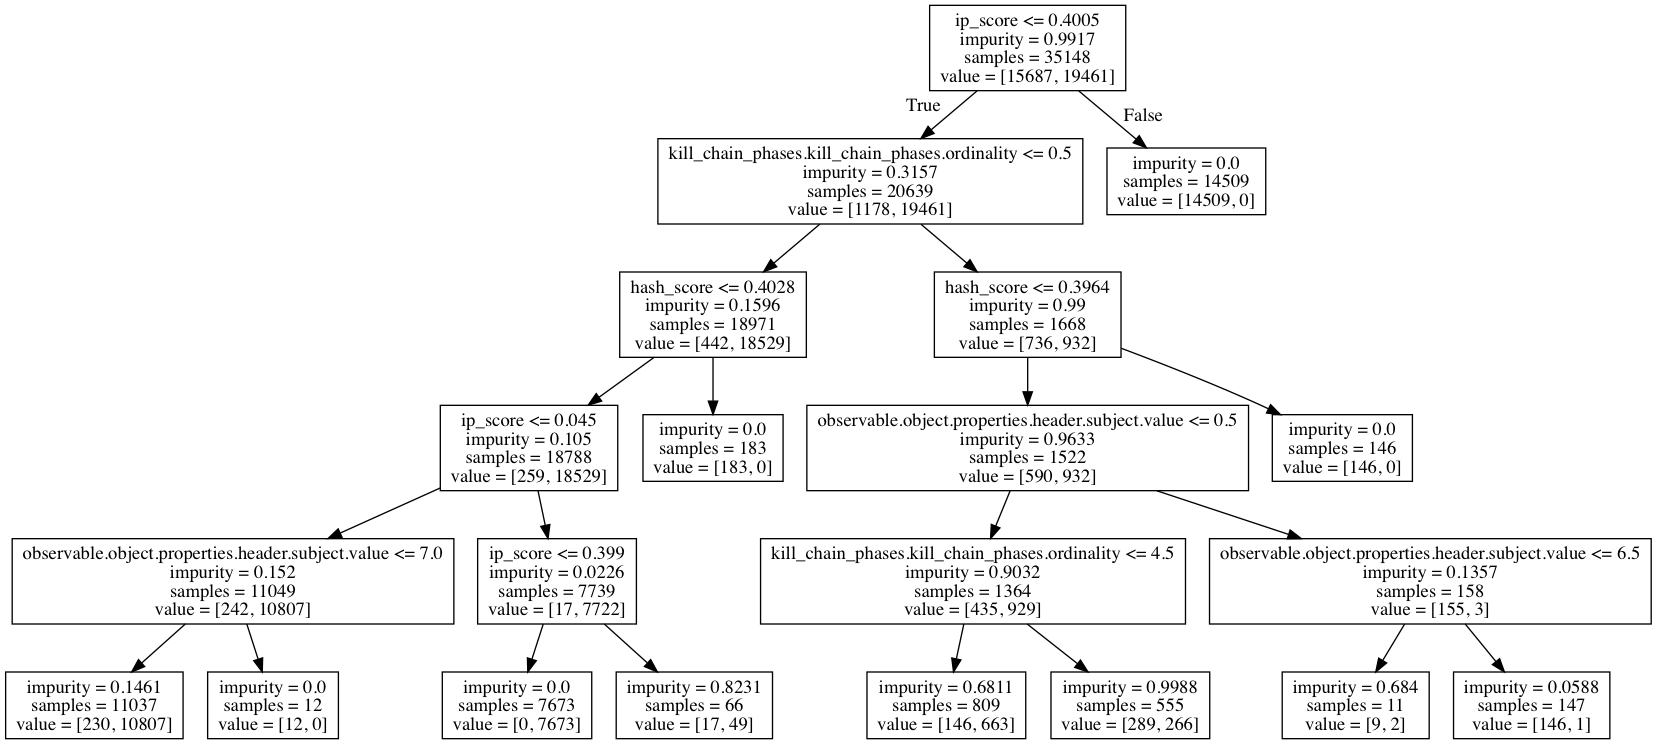

In [16]:
import os
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image

# Build a decision tree model on this data set
decision_tree = DecisionTreeClassifier(max_depth=5, criterion="entropy")
decision_tree.fit(X, Y)
Decision_Tree_Image(decision_tree, X.columns)

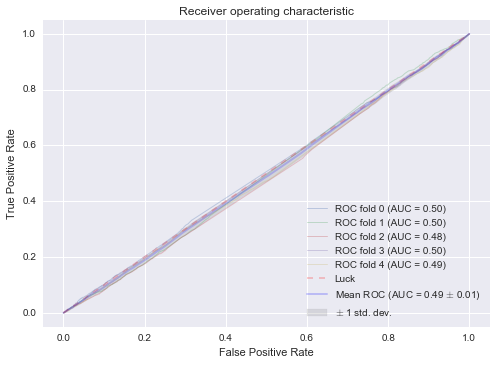

In [19]:
from scipy import interp
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier(n_estimators=25)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, Y):
    probas_ = classifier.fit(X.iloc[train], Y[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.2)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.2)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0) 
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()